#Python Advanced Topics

Author: Joe DeRose

Instead of diving deeply into any one particular package, the goal of this session will be to guide you through a few exercises that use packages that you may find useful in your research. 

To start, make sure you have the following packages installed:
- scikit-learn
- astropy
- healpy

In [31]:
%pylab inline
from astropy.table import Table
from astropy.io import fits
from sklearn import datasets, cross_validation, preprocessing, neighbors, metrics, grid_search
from matplotlib.colors import ListedColormap
import healpy as hp


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Reading, writing and manipulating data using astropy
Astropy is a [well documented](http://astropy.readthedocs.org/en/latest/index.html) library containing functionality useful for many every day astrophysical applications. 

First, we'll go over how to load and manipulate Flexible Image Transport System (FITS) files, a common binary format for astrophysical data.
There are a number of python packages with FITS reading functionality, but today we will focus on astropy.

In [32]:
hdulist = fits.open('COM_CompMap_CMB-commrul_0256_R1.00.fits')
hdulist.info()

Filename: COM_CompMap_CMB-commrul_0256_R1.00.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   ()              
1    COMP-MAP    BinTableHDU     56   786432R x 3C   [E, E, B]   
2    CMB-Sample  BinTableHDU     83   786432R x 10C   [E, E, E, E, E, E, E, E, E, E]   
3    BeamWF      BinTableHDU     41   1001R x 1C   [E]   


Opening a fits file gives us a list of the 'Header Data Units' or HDUs which contain the data that is stored in the file. The info method lists the properties of each of the HDUs

In [33]:
hdulist[1].header #We can take a look at the header of each of the HDUs to see what data it contains

XTENSION= 'BINTABLE'           /Written by IDL:  Thu Sep 12 15:01:21 2013       
BITPIX  =                    8 /                                                
NAXIS   =                    2 /Binary table                                    
NAXIS1  =                    9 /Number of bytes per row                         
NAXIS2  =               786432 /Number of rows                                  
PCOUNT  =                    0 /Random parameter count                          
GCOUNT  =                    1 /Group count                                     
TFIELDS =                    3 /Number of columns                               
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
EXTNAME = 'COMP-MAP'           /Extension name                                  
EXTVER  =                   

We can also write data in FITS format using astropy

In [36]:
#Let's select the data we care about to write to disk
whdu = hdulist[1]
col1 = whdu.columns['I']
col2 = whdu.columns['VALMASK']

In [38]:
cols = fits.ColDefs([col1, col2]) #Combine the columns together
tbhdu = fits.BinTableHDU.from_columns(cols) #and turn them into a table
tbhdu.writeto('intensity.fits', clobber=True) #write the table to disk

### Task 1
Read in the file that we just wrote and select the intensity map column.

In [ ]:
#Task 1 soln
ifits = fits.open('intensity.fits')
ifits[1].data['I']

##Healpy
Now that we've learned how to read and write FITS data using astropy, let's play around with the data we loaded.

[Healpy](https://healpy.readthedocs.org/en/latest/) is a very useful [HEALPix](http://healpix.jpl.nasa.gov/) manipulation package, among other things.  

Briefly, HEALPix is a commonly used decomposition of the sphere. It has useful properties such as:
- All pixels are equal in area
- Pixel centers lie on lines of constant latitude
- [many more](http://healpix.jpl.nasa.gov/pdf/intro.pdf)

A HEALPix map is characterized by its N<sub>side</sub> parameter, describing the number of divisions along the side of a base resolution pixel needed to obtain the desired decomposition. The number of pixels is then N<sub>pix</sub>=12N<sub>side</sub><sup>2</sup>.

In [39]:
nside = hdulist[1].header['NSIDE']
print(hp.nside2npix(nside))
print(len(hdulist[1].data)) #healpix map is just array w/ N_pix elements (N_side = 256 here)
print(hp.nside2pixarea(nside, degrees=True)) #area of pixels

786432
786432
0.0524558528257


In [41]:
#lots of nice coordinate conversion functionality
theta, phi = hp.pix2ang(nside, np.arange(12*nside**2), nest=True) #get angular locations of pixel centers
                                                                  #but be careful, depending on the coordinate system
                                                                  #used, they may not comply with typical conventions
vec = hp.ang2vec(theta, phi) #get unit vectors corresponding to those coordinates
print(theta[:5], phi[:5])

(array([ 1.56819216,  1.56558797,  1.56558797,  1.56298375,  1.56298375]), array([ 0.78539816,  0.78846612,  0.7823302 ,  0.78539816,  0.79153409]))


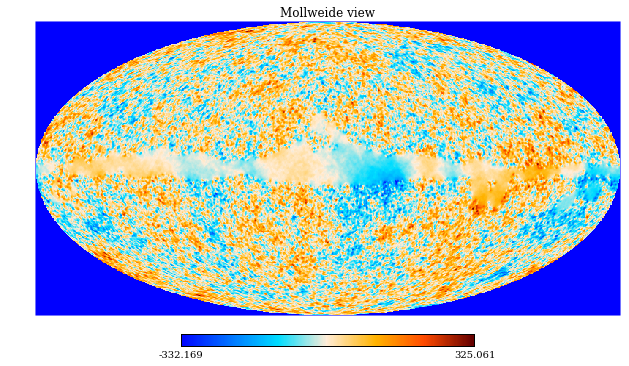

In [42]:
colormap = ListedColormap(np.loadtxt("Planck_Parchment_RGB.txt")/255.) #to make it pretty
hp.mollview(hdulist[1].data['I'], nest=True, cmap=colormap) #nested numbering scheme 

Healpix has some convinient coordinate transformation functions.

In [43]:
euler_angs = [45, 45, 0] #we can define an arbitraty rotation using Euler angles
rot = hp.Rotator(euler_angs, eulertype='XYZ')
print(rot.mat) #the rotation matrix in cartesian basis defined by euler_angs

[[ 0.5         0.5         0.70710678]
 [-0.70710678  0.70710678  0.        ]
 [-0.5        -0.5         0.70710678]]


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


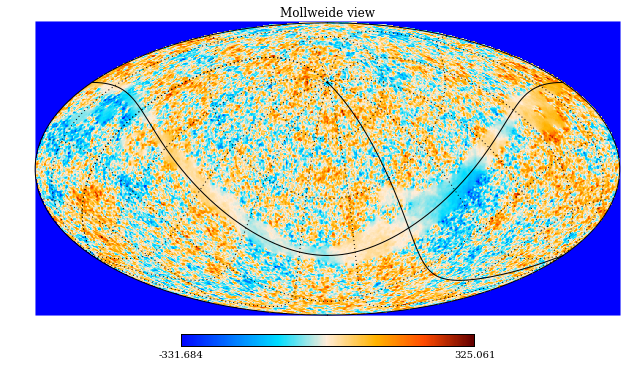

In [44]:
hp.mollview(hdulist[1].data['I'], nest=True, cmap=colormap, rot=euler_angs)
hp.graticule() #plot the graticule

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


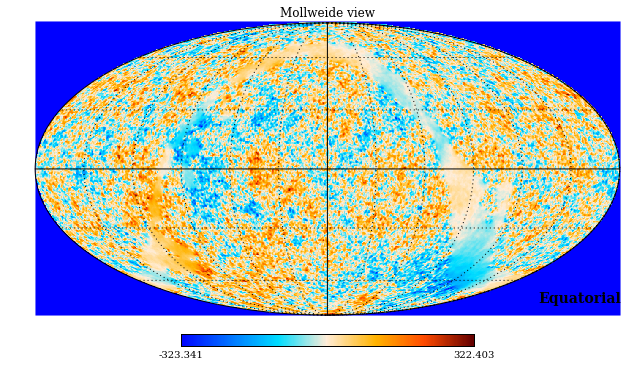

In [45]:
hp.mollview(hdulist[1].data['I'], nest=True, cmap=colormap, coord=['G', 'C'])
hp.graticule()

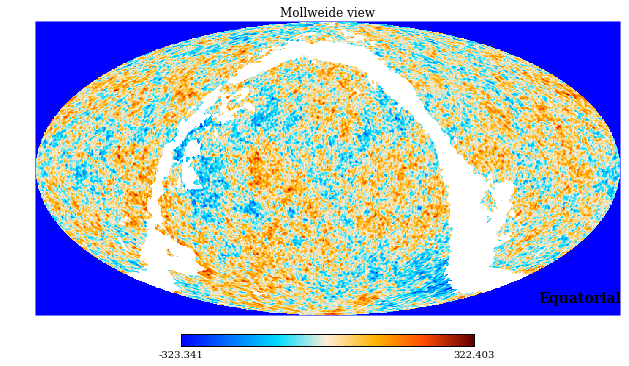

In [46]:
mmap = hp.ma(hdulist[1].data['I']) 
mmap.mask = np.logical_not(hdulist[1].data['VALMASK']) #we can mask out the galactic plane
hp.mollview(mmap, nest=True, cmap=colormap, coord=['G', 'C'])

Astropy has some very convenient coordinate transformation functionality as well.

In [47]:
from astropy import units as u
from astropy.coordinates import SkyCoord

ra = np.arange(10)
dec = np.arange(10)
c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
c = SkyCoord(ra, dec, frame='icrs', unit='deg') #alternatively
c

<SkyCoord (ICRS): (ra, dec) in deg
    [(0.0, 0.0), (1.0, 1.0), (2.0, 2.0), (3.0, 3.0), (4.0, 4.0),
     (5.0, 5.0), (6.0, 6.0), (7.0, 7.0), (8.0, 8.0), (9.0, 9.0)]>

In [48]:
c.galactic #to convert between different coordinate systems, just get the relevant attributes

<SkyCoord (Galactic): (l, b) in deg
    [(96.33728337, -60.18855195), (98.94104206, -59.64379646),
     (101.45696454, -59.04864754), (103.88202904, -58.40553106),
     (106.21439863, -57.7169344), (108.45329229, -56.98536542),
     (110.5988439, -56.2133176), (112.65195848, -55.4032417),
     (114.61417252, -54.55752339), (116.48752355, -53.67846653)]>

### Task 2
Mask out all pixels with RA>90 in the CMB map and plot them using the Mollweide projection.

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


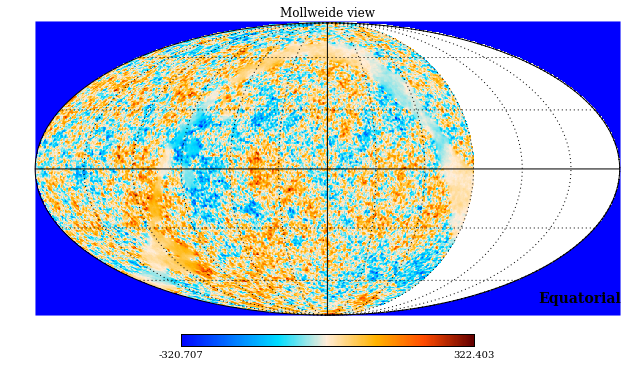

In [61]:
#task 2 soln
nmap = hp.ma(hdulist[1].data['I']) 
theta, phi = hp.pix2ang(nside, np.arange(len(hdulist[1].data['I'])), nest=True)
theta = theta-np.pi/2 #The angles that healpy spits do not follow the standard astro convention
phi = phi-np.pi
c = SkyCoord('galactic', b=theta, l=phi, unit='rad')
nmap.mask = (c.icrs.ra.deg)<90
hp.mollview(nmap, nest=True, cmap=colormap, coord=['G', 'C'])
hp.graticule()

##Scikit-learn
There is [a lot](http://scikit-learn.org/stable/) here, so we'll only just scratch the surface. There are a very large number of machine learning algorithms implemented in this package. I'll use just one for the purposes of this tutorial, focusing on a typical model building workflow.

We'll cover:
- Data pre-processing and feature selection
- Model selection/validation
- Model persistence

###Regression

In [49]:
boston = datasets.load_boston() #load in a canned data set 
X = boston.data
Y = boston.target
fields = boston.feature_names
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Let's take a look!

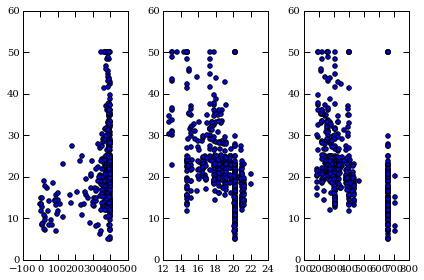

In [50]:
subplot(131)
scatter(X[:,11],Y)
subplot(132)
scatter(X[:,10],Y)
subplot(133)
scatter(X[:,9],Y)
tight_layout()

Note that the dynamical range of some of the features is much larger than that of others. Depending on the learning algorithm, this can lead to non-optimal performance, so it is always good practice to rescale your features.

In [51]:
X_scaled = preprocessing.scale(X)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X_scaled, Y, test_size=0.5)

We'll try to predict the price of the homes based on the other features based on a k-nearest neighbors algorithm. The most basic version of this algorithm predicts the label for the query point as the mean of the labels of the k nearest neighbors to the query point in feature space.

In [52]:
n_neighbors = 5
weights = 'uniform'
reg = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
reg.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=5, p=2, weights='uniform')

23.7129849802


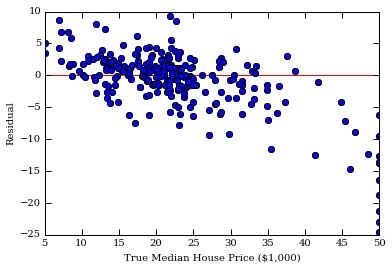

In [53]:
Y_pred = reg.predict(X_test)

# how well did we do?
mse = metrics.mean_squared_error(Y_test,Y_pred)
print(mse)
plot(Y_test,Y_pred - Y_test,'o')
xlabel("True Median House Price ($1,000)")
ylabel("Residual")
hlines(0,min(Y_test),max(Y_test),color="red")

### Task 3

Explore the KNN model parameters. See if you can find a combination that minimzes the MSE.

We can do this more systematically using the GridSearchCV sklearn function!

###Cross Validation and Model Selection

In [54]:
params = {'n_neighbors':range(1,5), 'weights':['uniform', 'distance']}
cvreg = grid_search.GridSearchCV(neighbors.KNeighborsRegressor(), params, n_jobs=-1)#n_jobs parameter sets the number of processors
cvreg.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'n_neighbors': [1, 2, 3, 4], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [55]:
cvreg.grid_scores_

[mean: 0.61198, std: 0.08512, params: {'n_neighbors': 1, 'weights': 'uniform'},
 mean: 0.61198, std: 0.08512, params: {'n_neighbors': 1, 'weights': 'distance'},
 mean: 0.61735, std: 0.12164, params: {'n_neighbors': 2, 'weights': 'uniform'},
 mean: 0.63735, std: 0.11365, params: {'n_neighbors': 2, 'weights': 'distance'},
 mean: 0.61883, std: 0.12899, params: {'n_neighbors': 3, 'weights': 'uniform'},
 mean: 0.65361, std: 0.10866, params: {'n_neighbors': 3, 'weights': 'distance'},
 mean: 0.62935, std: 0.09473, params: {'n_neighbors': 4, 'weights': 'uniform'},
 mean: 0.64953, std: 0.09411, params: {'n_neighbors': 4, 'weights': 'distance'}]

19.0598227566


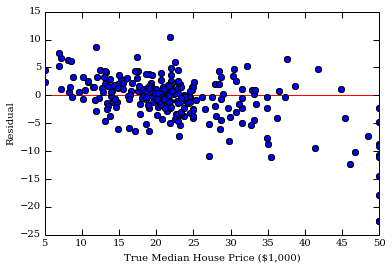

In [56]:
Y_pred = cvreg.predict(X_test)

# how well did we do?
mse = metrics.mean_squared_error(Y_test,Y_pred)
print(mse)
plot(Y_test,Y_pred - Y_test,'o')
xlabel("True Median House Price ($1,000)")
ylabel("Residual")
hlines(0,min(Y_test),max(Y_test),color="red")

Model Persistence

In [58]:
from sklearn.externals import joblib
joblib.dump( cvreg, 'cvreg.p')

['cvreg.p',
 'cvreg.p_01.npy',
 'cvreg.p_02.npy',
 'cvreg.p_03.npy',
 'cvreg.p_04.npy',
 'cvreg.p_05.npy',
 'cvreg.p_06.npy',
 'cvreg.p_07.npy',
 'cvreg.p_08.npy',
 'cvreg.p_09.npy',
 'cvreg.p_10.npy',
 'cvreg.p_11.npy',
 'cvreg.p_12.npy',
 'cvreg.p_13.npy',
 'cvreg.p_14.npy',
 'cvreg.p_15.npy',
 'cvreg.p_16.npy',
 'cvreg.p_17.npy',
 'cvreg.p_18.npy',
 'cvreg.p_19.npy',
 'cvreg.p_20.npy',
 'cvreg.p_21.npy',
 'cvreg.p_22.npy',
 'cvreg.p_23.npy',
 'cvreg.p_24.npy']

In [59]:
reload_reg = joblib.load('cvreg.p')


19.0598227566


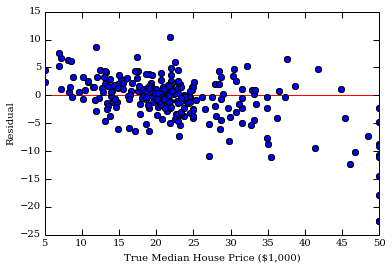

In [60]:
Y_pred = cvreg.predict(X_test)

# how well did we do?
mse = metrics.mean_squared_error(Y_test,Y_pred)
print(mse)
plot(Y_test,Y_pred - Y_test,'o')
xlabel("True Median House Price ($1,000)")
ylabel("Residual")
hlines(0,min(Y_test),max(Y_test),color="red")

###Classification

In [ ]:
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data
Y = iris.target



In [ ]:
# adapted from http://scikit-learn.org/0.13/auto_examples/svm/plot_iris.html#example-svm-plot-iris-py
from sklearn import svm
iris = datasets.load_iris()
X = iris.data[:, 1:3]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
Y = iris.target

h = .02  # step size in the mesh
print "feature vector shape=", X.shape
print "class shape=", Y.shape
print(iris.DESCR)



In [ ]:
plt.scatter(X[:,0], X[:,1], c=Y)

In [ ]:
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter

svc = svm.SVC(kernel='linear', C=C).fit(X, Y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, Y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, Y)
lin_svc = svm.LinearSVC(C=C).fit(X, Y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel',
          'LinearSVC (linear kernel)']


for i, clf in enumerate((svc, rbf_svc, poly_svc, lin_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    subplot(2, 2, i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    contourf(xx, yy, Z, cmap=plt.cm.rainbow)
    axis('off')

    # Plot also the training points
    scatter(X[:, 0], X[:, 1], c=Y, cmap=cm.rainbow)

    title(titles[i])